In [1]:
#!conda install pyvistaqt -y
#!conda install -c conda-forge cmocean -y

In [2]:
import pyvista as pv

import numpy as np

import glob
import natsort
import pyvistaqt
import matplotlib.pyplot as plt


In [3]:
import cmocean

In [4]:
fbase = '/media/dan/seagate_exansion/gadi/2dmodels/rifting/'

In [5]:
#modname = 'half_mantle_t102/'
modname = 'output_kerg_F3/'

pvtu_files = natsort.natsorted(glob.glob(fbase + modname + 'solution/*.pvtu')) 

In [6]:
i = -1
vtk_data = pv.read(pvtu_files[i])

scale = 2
vtk_data.points[:, 1] *= scale

In [7]:
#p = pyvistaqt.BackgroundPlotter()
#p.add_mesh(vtk_data, scalars = 'stripes', cmap='coolwarm')
#p.show()

In [8]:
#p.camera_position

In [9]:
cam_pos =[(95514.35309167023, 161975.97748789148, -211735.22931195388),
 (95514.35309167023, 161975.97748789148, 0.0),
 (0.0, 1.0, 0.0)]

In [10]:
#p.add_mesh?

#pv.Plane?

In [11]:
plane = pv.Plane(center=(100e3, 50.5e3, 1e3),
    direction=(0, 0, 1),
    i_size=200e3,
    j_size=101e3)


plane.points[:, 1] *= scale

## Setup threshold and contours

In [12]:
stripes_thresh  = vtk_data.threshold([0.75, 1.25], 
                              scalars='stripes', 
                              all_scalars=False)



stripes_sed1  = vtk_data.threshold([0.5, 1.9], 
                              scalars='sediment_1', 
                              all_scalars=False)

stripes_sed2  = vtk_data.threshold([0.5, 1.9], 
                              scalars='sediment_2', 
                              all_scalars=False)



vtk_data2 = vtk_data.copy()
vtk_data2.points[:,2] -= 2e3
temp_thresh = vtk_data2.threshold([0, 873], 
                              scalars='T')

2022-06-16 15:52:54.940 (   3.627s) [        5AC9A740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-16 15:52:55.025 (   3.713s) [        5AC9A740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-16 15:52:55.165 (   3.853s) [        5AC9A740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-16 15:52:55.388 (   4.076s) [        5AC9A740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.


In [13]:
contours = vtk_data.contour(isosurfaces=[673, 873, 1073], 
                             scalars='T')


sed_contours = vtk_data.contour(isosurfaces=[0.5], 
                             scalars='sediment_1')

In [17]:
#customise color bar

sargs = dict(
    title_font_size=32,
    label_font_size=20,
    height=0.25,
    shadow=True,
    n_labels=5,
    italic=True,
    #fmt="%.1f",
    font_family="arial",
    title = "differential stress (Pa)"
)

In [18]:
p = pv.Plotter( window_size = (1000, 600), border=True, border_color='black', border_width=2.0)


p.add_mesh(stripes_thresh, color="white", opacity = 0.9)


p.add_mesh(temp_thresh, scalars = 'plastic_strain',  cmap ='Greys', clim = [0.3, 1],
           opacity = 'sigmoid_r',  use_transparency=True, show_scalar_bar=False)

p.add_mesh(vtk_data, scalars = 've_stress_xx', clim = [-100e6, 100e6],
           cmap='coolwarm_r', opacity = 1.0, scalar_bar_args=sargs)


p.add_mesh(stripes_sed1, color='green', opacity = 1.0)
p.add_mesh(stripes_sed2, color='orange', opacity = 1.0)



p.add_mesh(contours, color="black", line_width=1.5)
p.add_mesh(sed_contours, color="black", line_width=1.)


p.add_mesh(plane, color="blue", opacity = 0.25)


p.camera_position = cam_pos


#save the figure

p.screenshot('./figs/stripes_sr.png')



p.render()
p.show()




ViewInteractiveWidget(height=600, layout=Layout(height='auto', width='100%'), width=1000)

## Customise color bar

## Sample over line

In [149]:
friction_angle =   20.
cohesion      = 20.e6

cohesion_weak = 0.5
friction_weak = 0.25

crust_thick = 20e3
crust_rho = 2900
mantle_rho = 3300

In [150]:
vtk_data = pv.read(pvtu_files[i])


In [151]:
#get the components of the full stress tesnor

dte_years = 10e3
y2s = 3.154e7
shear_mod = 1e10


vtk_data.point_arrays['full_stress_xx'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_xx']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_xx']/(dte_years*y2s*shear_mod))

vtk_data.point_arrays['full_stress_yy'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_yy']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_yy']/(dte_years*y2s*shear_mod))


vtk_data.point_arrays['full_stress_xy'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_xy']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_xy']/(dte_years*y2s*shear_mod))

/home/dan/anaconda3/envs/t21-pyvista/lib/python3.7/site-packages/pyvista/core/dataset.py:1404: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  PyvistaDeprecationWarning


In [164]:
surface_height = 101.e3

sampled = vtk_data.sample_over_line(pointa = (175e3, surface_height, 0), 
                                            pointb=(175e3, 50e3, 0),
                                            resolution=int(2e3)
                                 )



depths = sampled['Distance']
stress_xx = sampled.get_array('full_stress_xx')
stress_yy = sampled.get_array('full_stress_yy')
pressure = sampled.get_array('p')


lithpress = np.zeros_like(depths)
mask = depth < crust_thick
lithpress[mask] = depths[mask]*crust_rho*9.8

lithpress[np.invert(mask)] = crust_thick*crust_rho*9.8 + \
(depths[np.invert(mask)] - crust_thick)*mantle_rho*9.8

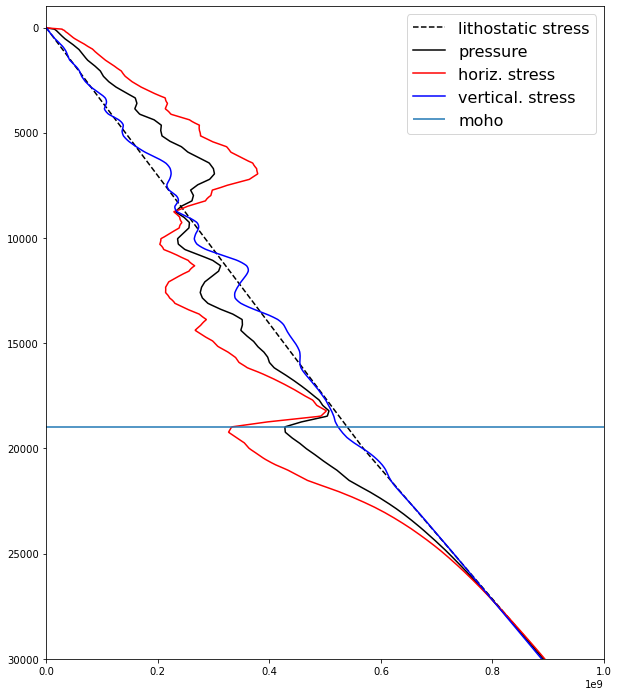

In [165]:
fig, ax = plt.subplots(figsize=(10, 12))


ax.plot(lithpress, depths, c = 'k', ls = '--',  label = 'lithostatic stress')
ax.plot(pressure,  depths, c = 'k', ls = '-', label = 'pressure')

#teh negative 1 signs make the stress and pressure sign conventions compatiable
ax.plot(pressure + -1*stress_xx,  depths, c = 'r',  label = 'horiz. stress')
ax.plot(pressure + -1*stress_yy,  depths, c = 'b', label = 'vertical. stress')

ax.set_ylim(30e3, -1e3)
ax.set_xlim(0, 1e9)

ax.hlines(20e3 - (surface_height - 100e3) , 0, 1e9, label = 'moho')

ax.legend(loc = 1, fontsize = 16)


In [194]:
#look at the expected differential stress from the Mohr Coulomb relatinship


fc0 = np.tan(np.deg2rad(friction_angle))
fc1 = np.tan(np.deg2rad(friction_weak*friction_angle))


mc_comp0 = -2*( fc0*lithpress)/(np.sqrt(fc0**2 + 1.) - fc0) - cohesion
mc_comp1 = -2*(fc1*lithpress)/(np.sqrt(fc1**2 + 1.) - fc1) - cohesion*cohesion_weak





mc_ext0 = 2*( fc0*lithpress)/(np.sqrt(fc0**2 + 1.) + fc0) + cohesion
mc_ext1 = 2*( fc1*lithpress)/(np.sqrt(fc1**2 + 1.) + fc1) + cohesion*cohesion_weak



In [195]:
fc0

0.36397023426620234

In [196]:
2*cohesion/((np.sqrt(fc0**2 + 1.) - fc0))

57125920.26968458

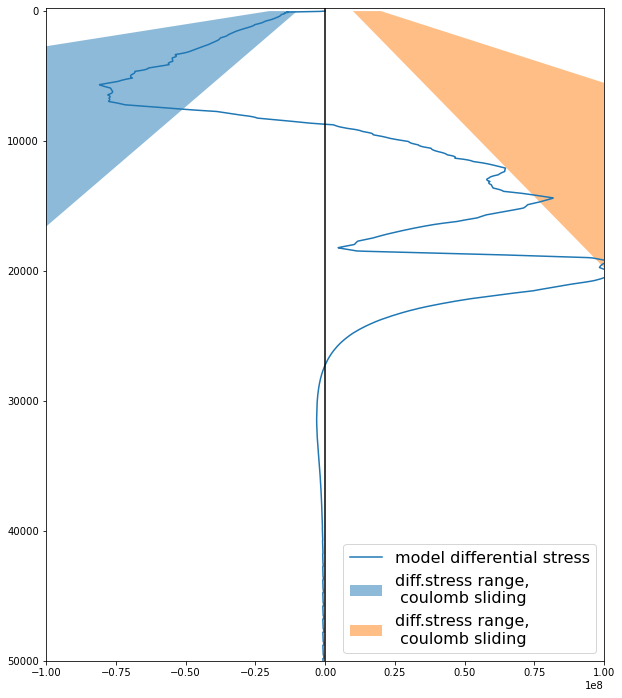

In [203]:
fig, ax = plt.subplots(figsize=(10, 12))


ax.plot(stress_xx, depth, label = 'model differential stress')
#ax.plot(mc_comp0, depth, c = 'r')
#ax.plot(mc_comp1, depth, c = 'b')

ax.fill_betweenx(depths, mc_comp0, mc_comp1, alpha = 0.5, label='diff.stress range, \n coulomb sliding')
ax.fill_betweenx(depths, mc_ext0, mc_ext1, alpha = 0.5, label='diff.stress range, \n coulomb sliding')


#ax.fill_between()

ax.set_ylim(50e3, -0.2e3)

ax.set_xlim(-100e6, 100e6)

ax.vlines(0,100e3, -1e3, colors = 'k' )

#ax.vlines(-20e6, 100e3, -1e3 )
#ax.vlines(-40e6, 100e3, -1e3 )

ax.legend(loc = 4, fontsize = 16)
